<a href="https://colab.research.google.com/github/EniolaWebsterEsho/Prediction-Codes/blob/main/GroundWaterLevelHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense


The dataset is available at https://waterdata.usgs.gov/monitoring-location/352315082484401. Monitoring location 352315082484401 is associated with a WELL in HAYWOOD COUNTY, NORTH CAROLINA. (Site 1)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Haywood_County_NC.csv to Haywood_County_NC.csv


In [3]:
df = pd.read_csv('Haywood_County_NC.csv', parse_dates=True)
df.head()

,Date,GWL1t,Et,precip,NETRAD,SWDown,LWDown,VPD_kPa,U10,U2,Tair,PSurf
0,1/1/2000,6.12,1.2759,0.0216,30.972721,105.713292,270.107083,0.125359,3.936278,2.944143,6.340000,89385.74917
1,1/2/2000,6.13,1.5367,0.0000,27.586476,116.885083,270.900000,0.124477,6.424808,4.805442,9.241667,89436.95792
2,1/3/2000,6.14,1.5751,0.1808,24.587280,112.307000,280.942500,0.149297,7.565854,5.658889,11.062083,89278.24958
3,1/4/2000,6.15,1.4269,6.4268,18.449987,50.218667,324.950833,0.130045,8.781460,6.568103,10.159167,88678.05250
4,1/5/2000,6.16,2.1501,0.0282,36.005409,125.498625,218.488750,0.105620,5.061672,3.785883,-2.307500,89118.60500


In [4]:
df.describe()

,GWL1t,Et,precip,NETRAD,SWDown,LWDown,VPD_kPa,U10,U2,Tair,PSurf
count,7282.000000,7305.000000,7304.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000
mean,5.261012,4.108924,3.640882,107.913961,189.789483,295.860032,0.320316,4.295023,3.211876,22.761434,89175.898959
std,0.948452,1.983640,8.826032,61.653550,71.903395,53.799749,0.205817,2.252325,1.685027,1033.102096,1146.888419
min,0.450000,-6.945900,0.000000,-77.040420,26.014875,0.120197,-0.034408,0.014440,-0.081250,-17.691250,1.704500
25%,4.730000,2.437700,0.000000,51.658770,129.078458,253.430417,0.165192,2.650433,1.981980,4.593750,88914.862500
50%,5.390000,4.080500,0.114050,110.085091,193.529833,304.622917,0.294779,3.974359,2.972538,11.954585,89248.145830
75%,5.970000,5.802600,2.963325,162.313881,249.669000,341.051667,0.443119,5.607649,4.194224,17.878761,89517.508330
max,6.960000,9.023900,125.565600,247.921423,331.853833,404.493750,7.573875,15.659211,11.712324,88306.415830,90626.235000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     7305 non-null   object 
 1   GWL1t    7282 non-null   float64
 2   Et       7305 non-null   float64
 3   precip   7304 non-null   float64
 4   NETRAD   7305 non-null   float64
 5   SWDown   7305 non-null   float64
 6   LWDown   7305 non-null   float64
 7   VPD_kPa  7305 non-null   float64
 8   U10      7305 non-null   float64
 9   U2       7305 non-null   float64
 10  Tair     7305 non-null   float64
 11  PSurf    7305 non-null   float64
dtypes: float64(11), object(1)
memory usage: 685.0+ KB


In [6]:
df['timestamp'] = pd.to_datetime(df['Date'])
df['Year'] = df.timestamp.dt.year
df['Month'] = df.timestamp.dt.month
df.head()
df.tail()

,Date,GWL1t,Et,precip,NETRAD,SWDown,LWDown,VPD_kPa,U10,U2,Tair,PSurf,timestamp,Year,Month
7300,12/27/2019,5.40,1.4796,0.0684,-22.663569,116.778917,220.271667,0.201657,4.402815,3.293091,9.145417,89543.48750,2019-12-27,2019,12
7301,12/28/2019,5.44,1.8146,0.9780,-53.799579,124.293667,188.136667,0.160877,3.147484,2.354164,10.284583,89593.23167,2019-12-28,2019,12
7302,12/29/2019,5.46,1.2317,8.0592,-53.845100,124.942292,200.525833,0.100012,7.590631,5.677421,12.872083,89013.20500,2019-12-29,2019,12
7303,12/30/2019,5.32,3.0291,12.8310,-18.417262,122.359708,224.143750,0.189872,7.598267,5.683132,10.067083,88276.32667,2019-12-30,2019,12
7304,12/31/2019,5.28,0.5168,NaN,73.452042,223.274583,0.120197,7.573875,5.664888,-0.081250,88306.415830,1.70450,2019-12-31,2019,12


In [7]:
df.drop(["Et","NETRAD","SWDown","LWDown","VPD_kPa","U10","U2","PSurf","Year","Month"],axis = 1, inplace=True)

In [8]:
df.head()

,Date,GWL1t,precip,Tair,timestamp
0,1/1/2000,6.12,0.0216,6.340000,2000-01-01
1,1/2/2000,6.13,0.0000,9.241667,2000-01-02
2,1/3/2000,6.14,0.1808,11.062083,2000-01-03
3,1/4/2000,6.15,6.4268,10.159167,2000-01-04
4,1/5/2000,6.16,0.0282,-2.307500,2000-01-05


In [9]:
df.isnull().sum()

Date          0
GWL1t        23
precip        1
Tair          0
timestamp     0
dtype: int64

In [10]:
df=df.dropna(axis=0,how='any')

In [11]:
df.isnull().sum()

Date         0
GWL1t        0
precip       0
Tair         0
timestamp    0
dtype: int64

In [12]:
df.head()

,Date,GWL1t,precip,Tair,timestamp
0,1/1/2000,6.12,0.0216,6.340000,2000-01-01
1,1/2/2000,6.13,0.0000,9.241667,2000-01-02
2,1/3/2000,6.14,0.1808,11.062083,2000-01-03
3,1/4/2000,6.15,6.4268,10.159167,2000-01-04
4,1/5/2000,6.16,0.0282,-2.307500,2000-01-05


In [13]:
MinMax_scaler = preprocessing.MinMaxScaler()
scaled_data = MinMax_scaler.fit_transform(df[['GWL1t','precip',"Tair"]])

In [14]:
scaled_df = df.copy()
scaled_df['GWL1t'] = scaled_data[:, 0]
scaled_df['precip'] = scaled_data[:, 1]
scaled_df['Tair'] = scaled_data[:, 2]
#scaled_df['Year'] = scaled_data[:, 3]
#scaled_df['Month'] = scaled_data[:, 4]
scaled_df.head()

,Date,GWL1t,precip,Tair,timestamp
0,1/1/2000,0.870968,0.000172,0.570390,2000-01-01
1,1/2/2000,0.872504,0.000000,0.639262,2000-01-02
2,1/3/2000,0.874040,0.001440,0.682470,2000-01-03
3,1/4/2000,0.875576,0.051183,0.661039,2000-01-04
4,1/5/2000,0.877112,0.000225,0.365139,2000-01-05


In [15]:
time_step = 1

In [16]:
#training_size = int(len(scaled_df) * 0.9)
#training, testing = scaled_df[0:training_size], scaled_df[training_size:len(df)]
#print('size of the dataset: %d' % (len(scaled_df)))
#print('Training examples: %d' % (len(training)))
#print('size of the test dataset: %d' % (len(testing)))
training_size = int(len(scaled_df) * 0.9)
training, testing = scaled_df[0:training_size], scaled_df[training_size:]
print('size of the dataset: %d' % (len(scaled_df)))
print('Training examples: %d' % (len(training)))
print('size of the test dataset: %d' % (len(testing)))

size of the dataset: 7281
Training examples: 6552
size of the test dataset: 729


In [17]:
#X_train = training[['GWL1t', 'precip','Tair','Year','Month']].to_numpy()
#Y_train = scaled_df[time_step:testing.index[0]]['GWL1t'].to_numpy()
x_train = training[['precip','Tair']].to_numpy()
y_train = training['GWL1t'].to_numpy()

In [18]:
#X_test = testing[0:-time_step][['GWL1t','precip','Tair','Year','Month']].to_numpy()
#Y_test = scaled_df[testing.index[0] + time_step:]['GWL1t'].to_numpy()
x_test = testing[['precip','Tair']].to_numpy()
y_test = testing['GWL1t'].to_numpy()

In [19]:
x_train.shape

(6552, 2)

In [20]:
y_train=y_train[:6552,]

In [21]:
y_train.shape

(6552,)

In [22]:
x_test=x_test[:705,]

In [23]:
x_test.shape

(705, 2)

In [24]:
y_test=y_test[:705,]

In [25]:
y_test.shape

(705,)

### **Linear Regression**

In [26]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

In [27]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)

In [28]:
y_pred.shape

(705,)

In [29]:
#The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R2_score: %.2f" % r2_score(y_test,y_pred))#

Coefficients: 
 [-0.3897911   0.10928405]
Mean squared error: 0.03
R2_score: -0.62


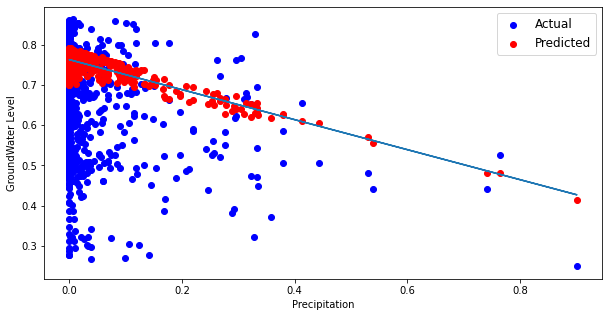

In [30]:
from scipy import stats

#turn array into a list
arr_x = x_test[:,0]
x = arr_x.tolist()
arr_y_pred = y_pred
y_p = arr_y_pred.tolist()

#Execute a method that returns some important key values of Linear Regression:
slope, intercept, r, p, std_err = stats.linregress(x, y_p)

#Create a function that uses the slope and intercept values to return a new value. 
#This new value represents where on the y-axis the corresponding x value will be placed:
def myfunc(x):
  return slope * x + intercept

#Run each value of the x array through the function. This will result in a new array with new values for the y-axis:
mymodel = list(map(myfunc, x))

#Draw the original scatter plot:
pyplot.figure(figsize=(10,5))
pyplot.scatter(x_test[:,0], y_test, color="blue", label = "Actual")
pyplot.scatter(x_test[:,0], y_pred, color="red", label ="Predicted")

#Draw the line of linear regression:
pyplot.plot(x, mymodel)

pyplot.xlabel("Precipitation")
pyplot.ylabel("GroundWater Level")
pyplot.legend(loc='upper right', fontsize='large')
pyplot.show()

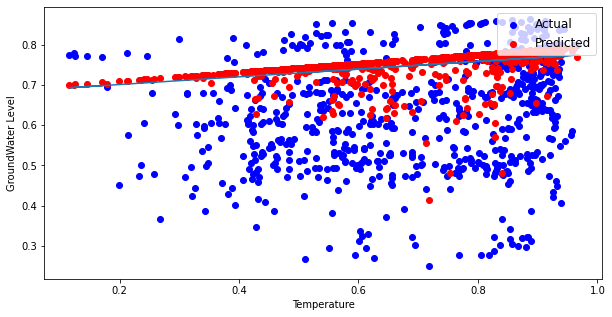

In [31]:
#turn array into a list
arr_x = x_test[:,1]
x = arr_x.tolist()
arr_y_pred = y_pred
y_p = arr_y_pred.tolist()

#Execute a method that returns some important key values of Linear Regression:
slope, intercept, r, p, std_err = stats.linregress(x, y_p)

#Create a function that uses the slope and intercept values to return a new value. 
#This new value represents where on the y-axis the corresponding x value will be placed:
def myfunc(x):
  return slope * x + intercept

#Run each value of the x array through the function. This will result in a new array with new values for the y-axis:
mymodel2 = list(map(myfunc, x))

#Draw the original scatter plot:
pyplot.figure(figsize=(10,5))
pyplot.scatter(x_test[:,1], y_test, color="blue", label = "Actual")
pyplot.scatter(x_test[:,1], y_pred, color="red", label ="Predicted")

#Draw the line of linear regression:
pyplot.plot(x, mymodel2)

pyplot.xlabel("Temperature")
pyplot.ylabel("GroundWater Level")
pyplot.legend(loc='upper right', fontsize='large')
pyplot.show()



In [32]:
#x_train_df_lr = pd.DataFrame(x_train, columns = ['GWL1t','precip','Tair'])
#X_train_df = X_train_df[0:23766]

In [33]:
#inverse_x_train_lr = MinMax_scaler.inverse_transform(x_train_df_lr[['GWL1t','precip','Tair']])
#inverse_y_train = MinMax_scaler.inverse_transform(x_train_df[['Gage Height', 'Year', 'Month','y_train']])

In [34]:
#x_test_df_lr = pd.DataFrame(x_test, columns = ['GWL1t','precip','Tair'])
#x_test_df_lr = x_test_df_lr[0:705]

In [35]:
#x_test_df_lr['predictions'] = y_pred
#x_test_df_lr['Y_test'] = y_test

In [36]:
#inverse_lr = MinMax_scaler.inverse_transform(x_test_df_lr[['Y_test','precip','Tair']])
#inverse2_lr = MinMax_scaler.inverse_transform(x_test_df_lr[['predictions','precip','Tair']])
#inverse3 = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year', 'Month', 'Discharge']])

In [37]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt
#mse = sqrt(mean_squared_error(inverse_lr[:,0], inverse2_lr[:,0]))
#print(mse)
#r2score = r2_score(inverse_lr[:,0], inverse2_lr[:,0])
#print(r2score)

In [38]:
from google.colab import files
uploaded = files.upload()

Saving Haywood_County_NC.csv to Haywood_County_NC (1).csv


In [39]:
df = pd.read_csv('Haywood_County_NC.csv', parse_dates=True)
df.head()

,Date,GWL1t,Et,precip,NETRAD,SWDown,LWDown,VPD_kPa,U10,U2,Tair,PSurf
0,1/1/2000,6.12,1.2759,0.0216,30.972721,105.713292,270.107083,0.125359,3.936278,2.944143,6.340000,89385.74917
1,1/2/2000,6.13,1.5367,0.0000,27.586476,116.885083,270.900000,0.124477,6.424808,4.805442,9.241667,89436.95792
2,1/3/2000,6.14,1.5751,0.1808,24.587280,112.307000,280.942500,0.149297,7.565854,5.658889,11.062083,89278.24958
3,1/4/2000,6.15,1.4269,6.4268,18.449987,50.218667,324.950833,0.130045,8.781460,6.568103,10.159167,88678.05250
4,1/5/2000,6.16,2.1501,0.0282,36.005409,125.498625,218.488750,0.105620,5.061672,3.785883,-2.307500,89118.60500


In [40]:
df.drop(["Et","NETRAD","SWDown","LWDown","VPD_kPa","U10","U2","PSurf"],axis = 1, inplace=True)

In [41]:
df['timestamp'] = pd.to_datetime(df['Date'])
df['Year'] = df.timestamp.dt.year
df['Month'] = df.timestamp.dt.month
df.head()

,Date,GWL1t,precip,Tair,timestamp,Year,Month
0,1/1/2000,6.12,0.0216,6.340000,2000-01-01,2000,1
1,1/2/2000,6.13,0.0000,9.241667,2000-01-02,2000,1
2,1/3/2000,6.14,0.1808,11.062083,2000-01-03,2000,1
3,1/4/2000,6.15,6.4268,10.159167,2000-01-04,2000,1
4,1/5/2000,6.16,0.0282,-2.307500,2000-01-05,2000,1


In [42]:
df=df.dropna(axis=0,how='any')

In [43]:
MinMax_scaler = preprocessing.MinMaxScaler()
scaled_data = MinMax_scaler.fit_transform(df[['GWL1t','precip',"Tair","Year","Month"]])

In [44]:
scaled_df = df.copy()
scaled_df['GWL1t'] = scaled_data[:, 0]
scaled_df['precip'] = scaled_data[:, 1]
scaled_df['Tair'] = scaled_data[:, 2]
scaled_df['Year'] = scaled_data[:, 3]
scaled_df['Month'] = scaled_data[:, 4]
scaled_df.head()

,Date,GWL1t,precip,Tair,timestamp,Year,Month
0,1/1/2000,0.870968,0.000172,0.570390,2000-01-01,0.0,0.0
1,1/2/2000,0.872504,0.000000,0.639262,2000-01-02,0.0,0.0
2,1/3/2000,0.874040,0.001440,0.682470,2000-01-03,0.0,0.0
3,1/4/2000,0.875576,0.051183,0.661039,2000-01-04,0.0,0.0
4,1/5/2000,0.877112,0.000225,0.365139,2000-01-05,0.0,0.0


In [45]:
testing.index

Int64Index([6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584,
            ...
            7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303],
           dtype='int64', length=729)

In [46]:
#training_size = int(len(scaled_df) * 0.9)
#training, testing = scaled_df[0:training_size], scaled_df[training_size:len(df)]
#print('size of the dataset: %d' % (len(scaled_df)))
#print('Training examples: %d' % (len(training)))
#print('size of the test dataset: %d' % (len(testing)))
training_size = int(len(scaled_df) * 0.9)
training, testing = scaled_df[0:training_size], scaled_df[training_size:len(df)]
print('size of the dataset: %d' % (len(df)))
print('Training examples: %d' % (len(training)))
print('size of the test dataset: %d' % (len(testing)))

size of the dataset: 7281
Training examples: 6552
size of the test dataset: 729


In [47]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asanyarray(data_sequences)

In [48]:
X_train = training[['GWL1t', 'precip','Tair','Year','Month']].to_numpy()
Y_train = scaled_df[time_step:testing.index[0]]['GWL1t'].to_numpy()
#x_train = training[['precip','Tair']].to_numpy()
#y_train = training['GWL1t'].to_numpy()

In [49]:
X_test = testing[0:-time_step][['GWL1t','precip','Tair','Year','Month']].to_numpy()
Y_test = scaled_df[testing.index[0] + time_step:]['GWL1t'].to_numpy()
#x_test = testing[['precip','Tair']].to_numpy()
#y_test = testing['GWL1t'].to_numpy()

In [50]:
XX_train = create_sequence(X_train, 48)
XX_test = create_sequence(X_test, 48)
Y_train = Y_train[-XX_train.shape[0]:]
Y_test = Y_test[-XX_test.shape[0]:]

In [51]:
XX_test.shape

(680, 48, 5)

In [52]:
Y_test.shape

(680,)

In [53]:
#print("XX_train shape = {}, and YY_train shape={}".format(XX_train.shape, YY_train.shape))

In [54]:
XX_train.shape

(6504, 48, 5)

In [55]:
XX_train.shape[-1]

5

### **Decision Tree Regression**

In [56]:
import tensorflow as tf
from tensorflow import keras

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
XX_train.shape

(6504, 48, 5)

In [59]:
XX_train_reshape= XX_train.reshape((6504,48*5))

In [60]:
Y_train.shape

(6504,)

In [61]:
Y_test.shape

(680,)

In [62]:
XX_test.shape

(680, 48, 5)

In [63]:
XX_test_reshape= XX_test.reshape((680,48*5))

In [64]:
tree = DecisionTreeRegressor()
tree.fit(XX_train_reshape, Y_train)


y_predictions = tree.predict(XX_test_reshape)

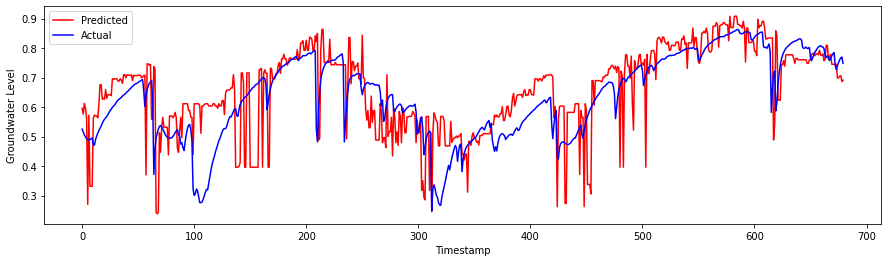

In [65]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(y_predictions, color='red', label='Predicted')
axs.plot(Y_test, color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [66]:
#The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test,y_predictions))
# The coefficient of determination: 1 is perfect prediction
print("R2_score: %.2f" % r2_score(Y_test,y_predictions))#

Coefficients: 
 [-0.3897911   0.10928405]
Mean squared error: 0.01
R2_score: 0.38


In [67]:
X_test.shape

(728, 5)

In [68]:
X_train_df_dt = pd.DataFrame(X_train, columns = ['GWL1t','precip','Tair','Year','Month'])
#X_train_df = X_train_df[0:23766]

In [69]:
inverse_X_train_dt = MinMax_scaler.inverse_transform(X_train_df_dt[['GWL1t','precip','Tair','Year','Month']])
#inverse_y_train = MinMax_scaler.inverse_transform(x_train_df[['Gage Height', 'Year', 'Month','y_train']])

In [70]:
X_test_df_dt = pd.DataFrame(X_test, columns = ['GWL1t','precip','Tair','Year','Month'])
X_test_df_dt = X_test_df_dt[0:680]

In [71]:
X_test_df_dt['predictions'] = y_predictions[:680]
X_test_df_dt['Y_test'] = Y_test

In [72]:
inverse_dt = MinMax_scaler.inverse_transform(X_test_df_dt[['Y_test','precip','Tair','Year','Month']])
inverse2_dt = MinMax_scaler.inverse_transform(X_test_df_dt[['predictions','precip','Tair','Year','Month']])
#inverse3 = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year', 'Month', 'Discharge']])

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(inverse_dt[:,0], inverse2_dt[:,0]))
print(mse)
r2score = r2_score(inverse_dt[:,0], inverse2_dt[:,0])
print(r2score)

0.716968187824914
0.3816255746468834


### **Random Forest Regressor**

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
rf = RandomForestRegressor()
rf.fit(XX_train_reshape, Y_train)


y_predictions_rf = rf.predict(XX_test_reshape)

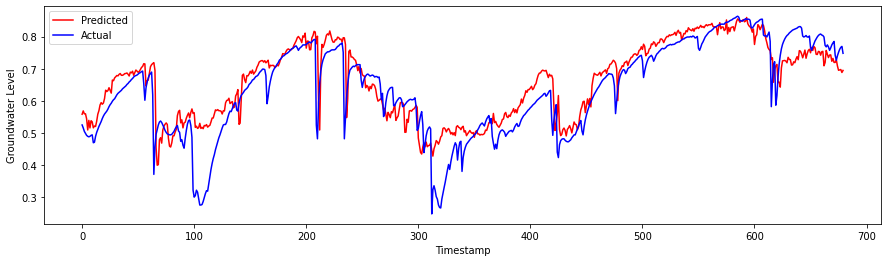

In [76]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(y_predictions_rf, color='red', label='Predicted')
axs.plot(Y_test, color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [77]:
#The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test,y_predictions_rf))
# The coefficient of determination: 1 is perfect prediction
print("R2_score: %.2f" % r2_score(Y_test,y_predictions_rf))#

Coefficients: 
 [-0.3897911   0.10928405]
Mean squared error: 0.00
R2_score: 0.75


In [78]:
X_train_df_rf = pd.DataFrame(X_train, columns = ['GWL1t','precip','Tair','Year','Month'])

In [79]:
#inverse_X_train_rf = MinMax_scaler.inverse_transform(X_train_df_rf[['GWL1t','precip','Tair','Year','Month']])

In [80]:
X_test_df_rf = pd.DataFrame(X_test, columns = ['GWL1t','precip','Tair','Year','Month'])
X_test_df_rf = X_test_df_rf[0:680]

In [81]:
X_test_df_rf['predictions'] = y_predictions_rf[:680]
X_test_df_rf['Y_test'] = Y_test

In [82]:
inverse_rf = MinMax_scaler.inverse_transform(X_test_df_rf[['Y_test','precip','Tair','Year','Month']])
inverse2_rf = MinMax_scaler.inverse_transform(X_test_df_rf[['predictions','precip','Tair','Year','Month']])

In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(inverse_rf[:,0], inverse2_rf[:,0]))
print(mse)
r2score = r2_score(inverse_rf[:,0], inverse2_rf[:,0])
print(r2score)

0.4564963878473158
0.7493161026101657


### **Neural Network: Multilayer Perceptron**



In [84]:
from sklearn.neural_network import MLPRegressor

In [85]:
regr_MLP = MLPRegressor(hidden_layer_sizes=(200,),random_state=1,max_iter=500).fit(XX_train_reshape, Y_train)
y_predictions_MLP = regr_MLP.predict(XX_test_reshape)

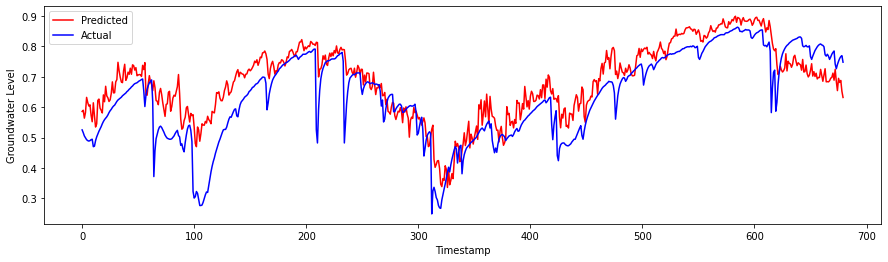

In [86]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(y_predictions_MLP, color='red', label='Predicted')
axs.plot(Y_test, color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [87]:
#The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test,y_predictions_MLP))
# The coefficient of determination: 1 is perfect prediction
print("R2_score: %.2f" % r2_score(Y_test,y_predictions_MLP))#

Coefficients: 
 [-0.3897911   0.10928405]
Mean squared error: 0.01
R2_score: 0.65


### **Bidirectional LSTM**

In [88]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout= 0.5, input_shape =(XX_train.shape[1], XX_train.shape[-1]))))
#model.add(Bidirectional(LSTM(32, dropout = 0.5)))
#model.add(Bidirectional(LSTM(16, dropout = 0.5)))
model.add(Bidirectional(LSTM(20, dropout = 0.5)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=opt)

In [89]:
#from keras.utils import plot_model

In [90]:
#tf.keras.utils.plot_model 

In [91]:
history = model.fit(XX_train, Y_train, batch_size=128, epochs=10, validation_split = 0.33)

Epoch 1/10
35/35 [==============================] - 14s 59ms/step - loss: 0.0592 - val_loss: 0.0166
Epoch 2/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0155 - val_loss: 0.0117
Epoch 3/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 4/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 5/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0128 - val_loss: 0.0165
Epoch 6/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0125 - val_loss: 0.0184
Epoch 7/10
35/35 [==============================] - 1s 17ms/step - loss: 0.0126 - val_loss: 0.0131
Epoch 8/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 9/10
35/35 [==============================] - 1s 17ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 10/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0105 - val_loss: 0.0104


In [92]:
predictions = history.model.predict(XX_test)

22/22 [==============================] - 2s 9ms/step


In [93]:
def evaluate_predictions(predictions, Y_test, outliers):
    ratio = []
    differences = []
    for pred in range (len(Y_test)):
        ratio.append((Y_test[pred]/predictions[pred])-1)
        differences.append(Y_test[pred] - predictions[pred]) 

    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)

    return ratio, differences, outliers

In [94]:
ratio, differences, outliers = evaluate_predictions(predictions, Y_test, 0.01)

In [95]:
for index in outliers.index:
    outliers[index] = predictions[index]
outliers

661    0.705815
657    0.709930
658    0.714454
656    0.707028
659    0.716525
662    0.707717
dtype: float64

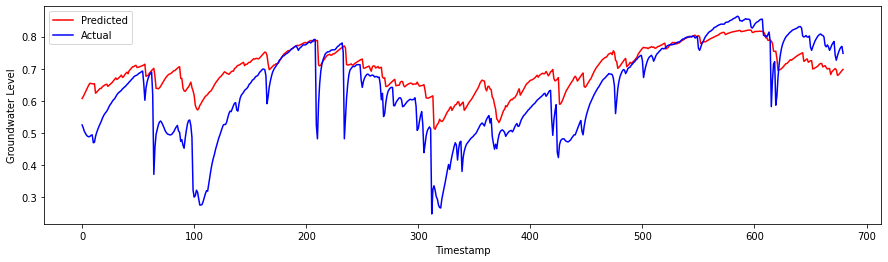

In [96]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(predictions, color='red', label='Predicted')
axs.plot(Y_test, color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [97]:
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
mape = sqrt(mean_absolute_percentage_error(Y_test, predictions))
print(mape)

0.4049587889250011


In [98]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(Y_test, predictions))
print(mse)
r2score_lstm = r2_score(Y_test, predictions)
print(r2score_lstm)

0.10748421114813381
0.41101657764808264


In [99]:
X_train_df = pd.DataFrame(X_train, columns = ['GWL1t','precip','Tair','Year','Month'])
#X_train_df = X_train_df[0:23766]

In [100]:
inverse_X_train = MinMax_scaler.inverse_transform(X_train_df[['GWL1t','precip','Tair','Year','Month']])
#inverse_y_train = MinMax_scaler.inverse_transform(x_train_df[['Gage Height', 'Year', 'Month','y_train']])

In [101]:
X_test_df = pd.DataFrame(X_test, columns = ['GWL1t','precip','Tair','Year','Month'])
X_test_df = X_test_df[0:680]

In [102]:
predictions.shape

(680, 1)

In [103]:
X_test_df['predictions'] = predictions[:680]
X_test_df['Y_test'] = Y_test

In [104]:
inverse = MinMax_scaler.inverse_transform(X_test_df[['Y_test','precip','Tair','Year','Month']])
inverse2 = MinMax_scaler.inverse_transform(X_test_df[['predictions','precip','Tair','Year','Month']])
#inverse3 = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year', 'Month', 'Discharge']])

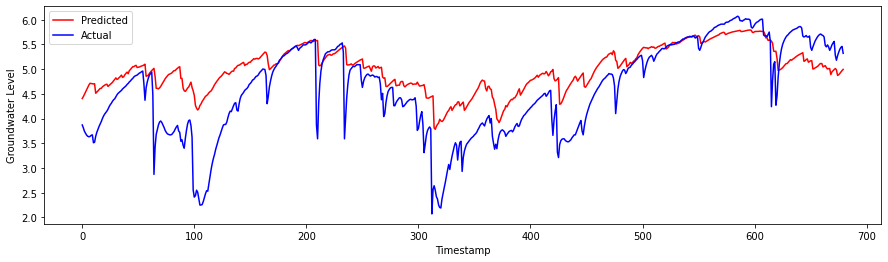

In [105]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(inverse2[:,0], color='red', label='Predicted')
axs.plot(inverse[:,0], color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [106]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(inverse[:,0], inverse2[:,0]))
print(mse)
r2score = r2_score(inverse[:,0], inverse2[:,0])
print(r2score)

0.699722214574351
0.4110165776480825


### **Arificial Neural Network**

In [107]:
model2 = Sequential([
    Dense(100, activation='relu', input_shape=(XX_train.shape[1], XX_train.shape[-1])),
    Dense(200, activation='relu' ),
    Dense(1, activation='relu')
])

In [108]:
model2.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [109]:
hist = model2.fit(XX_train, Y_train,
          batch_size=128, epochs=100, validation_split=0.2)

Epoch 1/100
41/41 [==============================] - 2s 15ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 1s 12ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 4/100
41/41 [==============================] - 0s 9ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 5/100
41/41 [==============================] - 0s 9ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 6/100
41/41 [==============================] - 0s 10ms/step - loss: 0.5720 - accuracy: 1.9220e-04 - val_loss: 0.6195 - val_accuracy: 0.0000e+00
Epoch 7/100
41/41 [==============================] - 0s 12ms/step - loss: 0.5720 - accuracy: 1.9220e-0

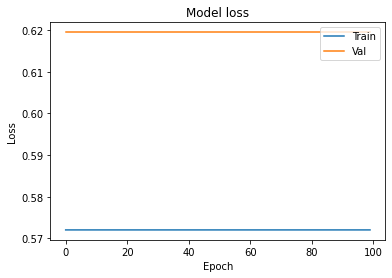

In [110]:
#visualize the training loss and the validation loss to see if the model is overfitting
pyplot.plot(hist.history['loss'])
pyplot.plot(hist.history['val_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Val'], loc='upper right')
pyplot.show()

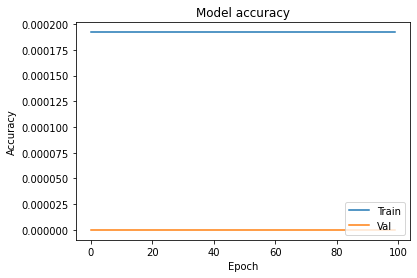

In [111]:
#visualize the training accuracy and the validation accuracy to see if the model is overfitting
pyplot.plot(hist.history['accuracy'])
pyplot.plot(hist.history['val_accuracy'])
pyplot.title('Model accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Val'], loc='lower right')
pyplot.show()

In [112]:
#Make a prediction & print the actual values
prediction = model.predict(XX_test)
#prediction  = [1 if y>=0.5 else 0 for y in prediction] #Threshold
#print(prediction)
#print(y_test)

22/22 [==============================] - 0s 7ms/step


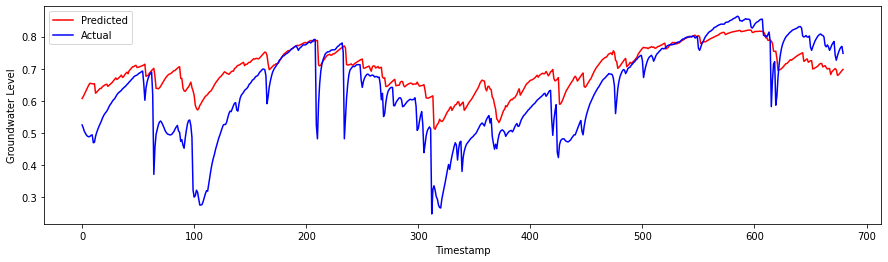

In [113]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(predictions, color='red', label='Predicted')
axs.plot(Y_test, color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

In [114]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(Y_test, predictions))
print(mse)
r2score_ann = r2_score(Y_test, predictions)
print(r2score_ann)

0.10748421114813381
0.41101657764808264
